# Buffering data

In some analysis it is necessary to find the influence of a feature in the surrounding areas, in this situation the `buffer` operation will help.

To create buffers, first add the `geopandas` package.

In [5]:
from pathlib import Path
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

base_path = Path.cwd().parents[0]
INPUT = base_path / "00_data"
OUTPUT = base_path / "out"

The input data is then loaded:

In [6]:
input_layer = gp.read_file(OUTPUT / "clipped.shp")[20:22]

`````{admonition}  
:class: danger
Since the input layer will be modified by the buffer operation, a copy of the input layer will be created.
`````


In [7]:
buffer_layer = input_layer.copy()

## Non-Overlapping Buffers

Using the `buffer` method, buffers are created by modifying the geometry of the input layer. The value defined within the buffer method is the size of the buffer and its unit depends on the coordinate system of the layer.

```{admonition} **Example of Units**
:class: note, dropdown
- WGS 84 (EPSG Code:4326): **Degrees**.
- ETRS89 / UTM Zone 32N (EPSG Code:25832): **Meters**.
```

In [8]:
buffer_layer['geometry'] = buffer_layer['geometry'].buffer(8)

The original layer and the result of the buffer is visualized using the parameters in the `plot` function: 
- `ax`: Overlays multiple plots on a map.
- `alpha`: Controls the transparency of the layers for better visualization. (ranges from 1 to 0 (fully transparent)) 

```{figure} ../resources/16.png
:width: 250px
:name: figure-example

Controlling transparency by `alpha` parameter in `plot` function
````


Also, the `Patch` function in `matplotlib`, creates a colored patch that can be used as a legend entry in a plot.

- `color`: sets the color of the patch
- `label`: specifies the lable of that color in the legend

Then `legend` function in `Matplotlib` adds the legend to a plot.

- `handles`: list of objects in the legend
- `loc`: specifies the location of the legend within the plot (lower left/right, upper left/right, center, lower/upper center)

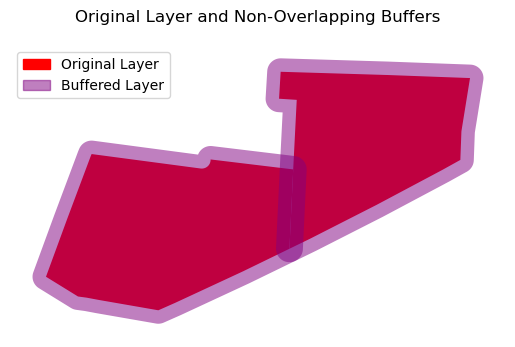

In [9]:
ax = input_layer.plot(color='red', alpha=1)
buffer_layer.plot(ax=ax, color='purple', alpha=0.5)

input_patch = mpatches.Patch(color='red', label='Original Layer')
buffer_patch = mpatches.Patch(color='purple', alpha=0.5, label='Buffered Layer')

ax.legend(handles=[input_patch, buffer_patch], loc='upper left')

ax.set_title("Original Layer and Non-Overlapping Buffers")
ax.set_axis_off()

The geometry column can be checked both before and after the `buffer` operation to observe the changes.

In [10]:
input_layer.head(3)

,KS_IS,CLC_st1,CLC18,CLC,Biotpkt201,Shape_Leng,Shape_Area,geometry
20,None,121,121,121.0,2.303538,463.517895,12562.667236,"POLYGON ((404542.292 5658252.886, 404589.39 56..."
21,None,112,112,112.0,6.600000,627.668797,17563.689623,"POLYGON ((404694.541 5658301.527, 404689.477 5..."


In [11]:
buffer_layer.head(3)

,KS_IS,CLC_st1,CLC18,CLC,Biotpkt201,Shape_Leng,Shape_Area,geometry
20,None,121,121,121.0,2.303538,463.517895,12562.667236,"POLYGON ((404532.805 5658256.02, 404532.911 56..."
21,None,112,112,112.0,6.600000,627.668797,17563.689623,"POLYGON ((404697.402 5658269.062, 404696.786 5..."


## Overlapping Buffers

When the layers are printed after `buffer` operation, the number of features remains the same. This indicates the buffer operation creates an individual buffer for each feature, rather than merging overlapping areas.

In [12]:
input_layer.shape

(2, 8)

In [13]:
buffer_layer.shape

(2, 8)

The `dissolve` function can merge all the buffers at once, creates a single feature from the whole dataset:

In [14]:
dissolved_buffer = buffer_layer.dissolve()
dissolved_buffer

,geometry,KS_IS,CLC_st1,CLC18,CLC,Biotpkt201,Shape_Leng,Shape_Area
0,"POLYGON ((404532.911 5658256.301, 404533.259 5...",None,121,121,121.0,2.303538,463.517895,12562.667236


If `only` the merging of `intersected buffers` is required, the overlapping areas need to be identified first. 

This can be done by overlaying the layer with itself to find the areas where the buffers intersect:

```{admonition} 
:class: note
- By using `how='inner'`, only the intersecting features will be included in the output.
```

In [15]:
intersected_buffers = gp.sjoin(
    buffer_layer, 
    buffer_layer[['CLC18','geometry']], 
    how="inner", 
    predicate="intersects")
intersected_buffers.head(5)

,KS_IS,CLC_st1,CLC18_left,CLC,Biotpkt201,Shape_Leng,Shape_Area,geometry,index_right,CLC18_right
20,None,121,121,121.0,2.303538,463.517895,12562.667236,"POLYGON ((404532.805 5658256.02, 404532.911 56...",20,121
20,None,121,121,121.0,2.303538,463.517895,12562.667236,"POLYGON ((404532.805 5658256.02, 404532.911 56...",21,112
21,None,112,112,112.0,6.600000,627.668797,17563.689623,"POLYGON ((404697.402 5658269.062, 404696.786 5...",20,121
21,None,112,112,112.0,6.600000,627.668797,17563.689623,"POLYGON ((404697.402 5658269.062, 404696.786 5...",21,112


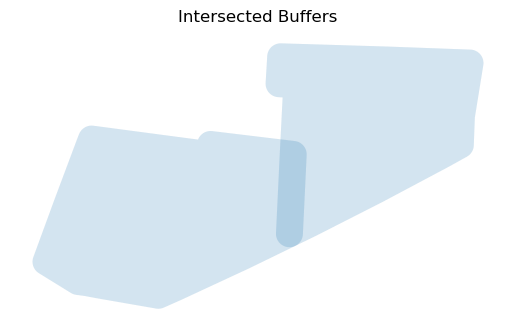

In [16]:
ax = intersected_buffers.plot(alpha= 0.1)
ax.set_title("Intersected Buffers")
ax.set_axis_off()

Then the `dissolve` operation is performed to merge **only the intersected buffers**.

In [20]:
dissolving_buffer = intersected_buffers.dissolve()
dissolving_buffer

,geometry,KS_IS,CLC_st1,CLC18_left,CLC,Biotpkt201,Shape_Leng,Shape_Area,index_right,CLC18_right
0,"POLYGON ((404533.259 5658257.01, 404533.675 56...",None,121,121,121.0,2.303538,463.517895,12562.667236,20,121


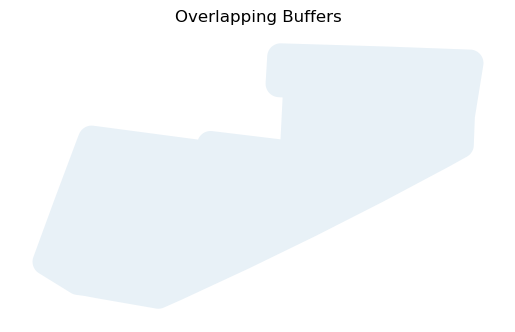

In [21]:
ax = dissolving_buffer.plot(alpha= 0.1)
ax.set_title('Overlapping Buffers')
ax.set_axis_off()

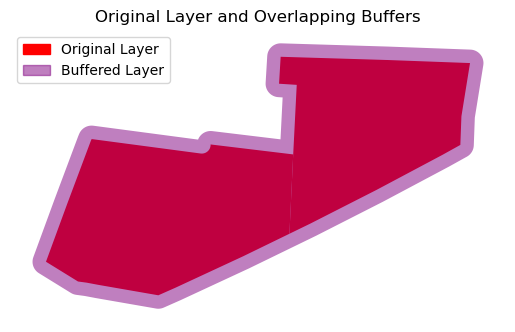

In [22]:
ax = input_layer.plot(color='red', alpha=1)
dissolving_buffer.plot(ax=ax, color='purple', alpha=0.5)

input_patch = mpatches.Patch(color='red', label='Original Layer')
buffer_patch = mpatches.Patch(color='purple', alpha=0.5, label='Buffered Layer')

ax.legend(handles=[input_patch, buffer_patch], loc='upper left')

ax.set_title("Original Layer and Overlapping Buffers")
ax.set_axis_off()

For comparison:

```{figure} ../resources/18.png
:height: 200px
:name: figure-example

Non-Overlapping VS Overlapping Buffers
````

```{admonition} **Buffer Parameters**
:class: tip, dropdown
In addition to the `distance` parameter, which indicates the size of the buffer, there are other parameters that help in processing and visualizing the output. 

`resolution` is a parameter that defines the number of segments used to create a quarter circle. The larger values for this parameter cause slower processing.

`cap_style`defines the shape of the end of the buffer, which is mostly used for line features. 
- cap_style = **1** defines **Round** shape.
- cap_style = **2** defines **Flat** shape.
- cap_style = **3** defines **Square** shape.

`join_style` defines the shape of the corner and edges in the buffers.
- join_style = **1** defines **Round** shape.
- join_style = **2** defines **Mitre** shape.
- join_style = **3** defines **Bevel** shape.
```

```{figure} https://geopandas.org/en/stable/_images/buffer.png
:height: 500px
:name: figure-example

Visualization of Buffer Parameters (Source: [GeoPandas website](https://geopandas.org/en/stable/_images/buffer.png)).
```

In [23]:
input_layer = gp.read_file(OUTPUT / "clipped.shp")[:1]
buffer_layer = input_layer.copy()

The following code creates a buffer of:
- 20 (The unit depends on the CRS),
- with a resolution of 8,
- round ends,
- and beveled corners.

In [24]:
buffer_layer['geometry'] = input_layer['geometry'].buffer(
    distance=20, 
    resolution=8, 
    cap_style=2, 
    join_style=3)

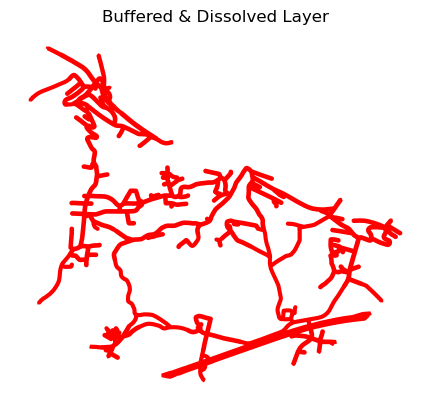

In [25]:
ax = buffer_layer.plot(color='red')
ax.set_title("Buffered & Dissolved Layer")
ax.set_axis_off()

## Negative buffer

Sometimes a feature is so large that it affects the analysis. In such cases, a negative buffer is defined to reduce the impact of the feature itself.

The desired feature or dataset is loaded first.

In [26]:
First_layer = gp.read_file(OUTPUT / "clipped.shp")[1:2]
copy_layer = First_layer.copy()

In this case, simply define a negative value for the `distance` parameter, instead of a positive value.

In [27]:
copy_layer['geometry'] = copy_layer['geometry'].buffer(distance= -4) 

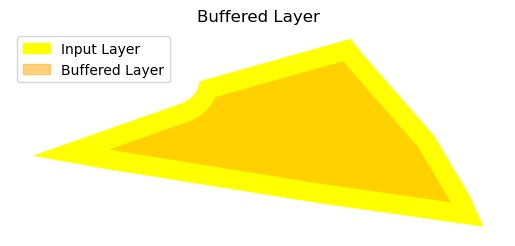

In [28]:
ax = First_layer.plot(color='yellow', alpha=1)
copy_layer.plot(ax=ax, color='orange', alpha=0.5)

input_patch = mpatches.Patch(color='yellow', label='Input Layer')
buffer_patch = mpatches.Patch(color='orange', alpha=0.5, label='Buffered Layer')

ax.legend(handles=[input_patch, buffer_patch], loc='upper left')

ax.set_title("Buffered Layer")
ax.set_axis_off()

## Multi-Ring Buffers

To analyze the effect of a feature at different distances, it can be helpful to create concentric buffer zones (multi-ring buffers) around the feature.

As these buffers needed to combine the `pandas` library should be imported. 

In [29]:
import pandas as pd

The data is loaded.

In [30]:
First_layer = gp.read_file(OUTPUT / "clipped.shp")[2:3]
copied_layer = First_layer.copy()

The buffer distances are defined as a list.

In [31]:
distances = [ -0.2, 4, 10] 

An empty list is created for containing the buffers for the defined distances.

In [32]:
buffer_data = []

A `for loop` is used to generate buffers around each feature in the dataset. 

Then both the distances and the geometry of buffers store in the empty list that already created.

In [33]:
for items in distances:
    buffered_geom = copied_layer.geometry.buffer(items)
    for geom in buffered_geom:
        buffer_data.append({'geometry': geom, 'distance': items})

Then the list converts to a GeoDataFrame.

In [34]:
buffers = gp.GeoDataFrame(buffer_data)

In [35]:
print (buffers)

                                            geometry  distance
0  POLYGON ((402993.661 5658109.321, 402994.216 5...      -0.2
1  POLYGON ((402989.932 5658106.707, 402989.542 5...       4.0
2  POLYGON ((402983.705 5658107.102, 402983.679 5...      10.0


All the buffers can then be plotted together in the same window:

First, a separate layer is created for each buffer distance by selecting the corresponding distance variable.

In [36]:
buffers_2 = buffers[buffers['distance'] == -0.2]
buffers_4 = buffers[buffers['distance'] == 4]
buffers_10 = buffers[buffers['distance'] == 10]

Then as already mentioned in this section, using the `ax` parameter the layers overlay for visualization.

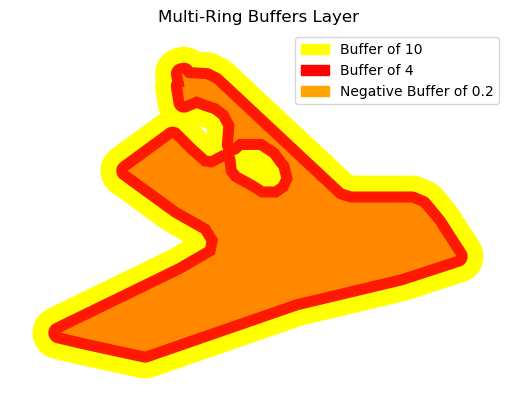

In [37]:
ax = buffers_10.plot(color='yellow', label='Buffer of 10')
buffers_4.plot(ax=ax, color='red', alpha= 0.9,label='Buffer of 4')
buffers_2.plot(ax=ax, color='orange', alpha= 0.8,label='Negative Buffer of 0.2')

#legend
legend_handles = [
    mpatches.Patch(color='yellow', label='Buffer of 10'),
    mpatches.Patch(color='red', label='Buffer of 4'),
    mpatches.Patch(color='orange', label='Negative Buffer of 0.2')

]
ax.set_axis_off()  
plt.title("Multi-Ring Buffers Layer")
plt.legend(handles=legend_handles)
plt.show()


Also to be able to compare the created buffers for each feature, radio button can be helpful.

For this reason, the `ipywidgets` library and `interactive` function added allow the creation of an interactive widget for comparing.

In [38]:
import ipywidgets as w
from ipywidgets import interactive

The `RadioButtons` function then used to create the radio buttons for the user to select from. 

- `value`: Default selected value
- `options`: Options for radio buttons
- `description`: Title for the button lists 

In [39]:
radiobutton = w.RadioButtons(
    value= -0.2,                    
    options=[10, 4, -0.2],       
    description="Buffer Distance",
)

Then, a function is defined that plots the selected buffer layer based on the button selected in the radio buttons. 

Then, using the `interactive` function, the function and the widget are linked.

interactive(function_name, parameter1=widget1, parameter2=widget2, ...)

**ex:** interactive_plot = interactive(plot_layers, radiobutton= radiobutton)

- first radiobutton: parameter which has been called in the plot_layers function
- second radiobutton: radiobutton widget that already created to select


In [ ]:
def plot_layers(radiobutton):
    fig, ax = plt.subplots()

    copied_layer.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2, alpha=1)

    if radiobutton == 10:
        buffers_10.plot(ax=ax, color='red', alpha=0.5)
    elif radiobutton == 4:
        buffers_4.plot(ax=ax, color='yellow', alpha=0.5)
    elif radiobutton == -0.2:
        buffers_2.plot(ax=ax, color='orange', alpha=0.5)

    legend_handles = [
    mpatches.Patch(edgecolor='black', facecolor='none', label='Original Layer'),
    mpatches.Patch(color='red', label='Buffer of 10'),
    mpatches.Patch(color='yellow', label='Buffer of 4'),
    mpatches.Patch(color='orange', label='Negative Buffer of 0.2')]
    plt.legend(handles=legend_handles)

    ax.set_title("Original Layer with Buffers")
    ax.set_axis_off()

    plt.show()

interactive_plot = interactive(plot_layers, radiobutton= radiobutton)

display(interactive_plot)